In [13]:
import torch
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
import torchvision.models as models
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from torchvision.transforms.transforms import RandomAffine
from torch.nn.common_types import T
dataset_path = "/content/drive/MyDrive/competitions/digit_recognizer/data" # @param {type:"string"}
batch_size = 512
test_batch_size = 1
n_epoch = 64
load_trained_model = True
transform = transforms.Compose([transforms.RandomAffine(degrees=20, translate=[3/28,3/28], scale=[0.9,1.05])])
model_path = "/content/drive/MyDrive/competitions/digit_recognizer/models/model1.pth"
#lr_init = 0.01

if not os.path.exists(dataset_path): # check dataset_path
  print('invalid dataset_path')


In [15]:
class datasets_from_csv():
  def __init__(self, dataset_file, transform=transforms.Compose([]), idx=[0]): # read digit data from a csv file
    self.transform = transform
    data = pd.read_csv(dataset_file)

    if 'label' in data: # if the dataset is train data
      self.dataset_type = 'train'
      self.inputs = torch.tensor(data.drop('label', axis=1).values).reshape([-1,1,28,28])/255
      self.target = torch.tensor(data['label'].values)
      if len(idx) > 1:
        self.inputs = self.inputs[idx[0] : idx[1]]
        self.target = self.target[idx[0] : idx[1]]
    else: # if the dataset is test data
      self.dataset_type = 'test'
      self.inputs = torch.tensor(data.values).reshape([-1,1,28,28])/255
      if len(idx) > 1:
        self.inputs = self.inputs[idx[0], idx[1]]

  def __getitem__(self, idx):
    if self.dataset_type == 'train':
      # return self.inputs[idx], self.target[idx]
      return self.transform(self.inputs[idx]), self.target[idx]
    else:
      return self.inputs[idx]
  
  def __len__(self):
    return len(self.inputs)
    

def make_dataloaders(train_dataset, val_dataset, test_dataset):
  trainloader = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True, drop_last=False)
  valloader = torch.utils.data.DataLoader(val_dataset, pin_memory=True, batch_size=batch_size, shuffle=True, drop_last=False)
  testloader = torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=test_batch_size, shuffle=False, drop_last=False)

  return trainloader, valloader, testloader

In [16]:
class _resblock(nn.Module):
  def __init__(self, input_channel, output_channel, kernel_size=3, stride=1, padding=1):
    super(_resblock, self).__init__()
    self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size, 1, padding)
    self.bn1 = nn.BatchNorm2d(output_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size, stride, padding)
    self.bn2 = nn.BatchNorm2d(output_channel)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    return x

class ResNet(nn.Module):
  def __init__(self, input_channel=1, output_channel=10):
    super(ResNet, self).__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel

    self.c1 = 8

    self.resblock1 = _resblock(1, self.c1, 3, 1)
    self.resblock2 = _resblock(self.c1, self.c1, 3, 1)
    self.resblock3 = _resblock(self.c1, self.c1*2, 3, 2)
    self.resblock4 = _resblock(self.c1*2, self.c1*2, 3, 1)
    self.resblock5 = _resblock(self.c1*2, self.c1*4, 3, 2)
    self.resblock6 = _resblock(self.c1*4, self.c1*4, 3, 1)
    self.resblock7 = _resblock(self.c1*4, self.c1*4, 3, 1)

    self.conv1 = nn.Conv2d(self.c1, self.c1*2, 1)
    self.conv2 = nn.Conv2d(self.c1*2, self.c1*4, 1)

    self.fc = nn.Linear(self.c1*4, 10)
    self.avg_pool = nn.AvgPool2d(2, 2)

    self.global_avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()

  
  def forward(self, inputs):
    x = self.relu(self.resblock1(inputs)) + inputs
    x = self.relu(self.resblock2(x)) + x
    x = self.relu(self.resblock3(x)) + self.conv1(self.avg_pool(x))
    x = self.relu(self.resblock4(x)) + x
    x = self.relu(self.resblock5(x)) + self.conv2(self.avg_pool(x))
    x = self.relu(self.resblock6(x)) + x
    x = self.relu(self.resblock7(x)) + x

    x = self.global_avgpool(x)
    x = self.fc(x.reshape(-1, self.c1*4))

    return x.reshape(-1, self.output_channel)


In [17]:
def train(model, train_loader, val_loader, n_epoch, lossfn=nn.CrossEntropyLoss()):

  optimizer = torch.optim.Adam(model.parameters())
  scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)
  pbar_epoch = tqdm(range(n_epoch))
  avg_train_loss = None
  avg_val_loss = None

  for epoch in pbar_epoch:
    train_loss = []
    val_loss = []
    collect = 0
    data_cnt = 0
    pbar_epoch.set_description(f'Epoch')
    pbar_trainloader = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc='train')

    model.train()
    for i, data in pbar_trainloader:
      optimizer.zero_grad()
      inputs, target = data
      outputs = model(inputs) # estimation
      loss = lossfn(outputs, target) # calculate loss score
      train_loss.append(loss.detach()) # to keep loss score
      loss.backward()
      optimizer.step()
    
    scheduler.step() 
    avg_train_loss = np.average(np.array(train_loss))
    pbar_epoch.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss)

    pbar_valloader = tqdm(enumerate(val_loader), total=len(val_loader), leave=False, desc='validation')

    model.eval()
    with torch.no_grad():
      for i, data in pbar_valloader:
        inputs, target = data
        outputs = model(inputs) # estimation
        loss = lossfn(outputs, target) # calculate loss score
        val_loss.append(loss.detach()) # to keep loss score
        _, idx = torch.max(outputs, 1)
        collect += (idx == target).sum().detach().numpy()
        data_cnt += len(target)
    
    avg_val_loss = np.average(np.array(val_loss))
    pbar_epoch.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss, acc=collect/data_cnt)

  return model

In [18]:
train_data_file = os.path.join(dataset_path, 'train.csv')
test_data_file = os.path.join(dataset_path, 'test.csv')

train_dataset = datasets_from_csv(train_data_file, transform=transform, idx=[0, 37800])
val_dataset = datasets_from_csv(train_data_file, idx=[37800, -1])
test_dataset = datasets_from_csv(test_data_file)

train_loader, val_loader, test_loader = make_dataloaders(train_dataset,
                                                         val_dataset, 
                                                         test_dataset)

In [30]:
model = ResNet()

if load_trained_model:
  model.load_state_dict(torch.load(model_path))
else:
  model = train(model, train_loader, val_loader, n_epoch)

In [20]:
def test(model, test_loader, n_show=3):
  output = []
  model.eval()
  with torch.no_grad():
    for data in tqdm(test_loader):
      out = np.array(model(data).detach()).flatten()
      out = out.argmax()
      output.append(out)

  return np.array(output)

In [21]:
submission = test(model, test_loader)

  0%|          | 0/28000 [00:00<?, ?it/s]

In [22]:
submission_df = pd.DataFrame(np.array([np.arange(len(submission))+1, submission]).transpose(), columns=['ImageID', 'Label'])
submission_df.to_csv(os.path.join(dataset_path, 'submission.csv'), index=False)

  0%|          | 0/74 [00:00<?, ?it/s]

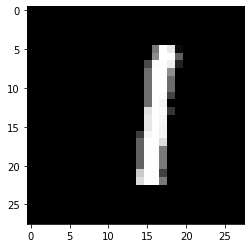

In [23]:
# data visualization

target_idx = 0

with torch.no_grad():
  for i, data in enumerate(tqdm(train_loader)):
    if i == target_idx:
      inputs, target = data
      inputs = inputs[0].reshape(28, 28)
      plt.imshow(inputs, cmap = "gray")
      break

In [28]:
# saving model

torch.save(model.state_dict(), model_path)